In [1]:
import torch
from torchvision import datasets
import numpy as np
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
import torch.nn.functional as F

if 'google.colab' in sys.modules:
    !pip install torchsummary

from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

from model_v0 import Net

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
logger.info(f"Using device = {device}")

In [3]:
# Mean and Standard Deviation of CIFAR-10 dataset
CIFAR10_MEAN = (0.49139968, 0.48215827, 0.44653124)
CIFAR10_STD = (0.24703233, 0.24348505, 0.26158768)
BATCH_SIZE = 32
CIFAR10_LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
GET_DATASET_STATS_FLAG = True

train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

cifar_train_dataset = datasets.CIFAR10(
    root='../../',
    train=True, 
    download=True,
    transform=train_transforms, 
    )

cifar_test_dataset = datasets.CIFAR10(
    root='../../',
    train=False, 
    download=True,
    transform=test_transforms, 
    )


train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 2, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 2, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

/Users/aravinddchakravarti/Documents/4_Deep_Learning/ERAv4/ERAv4/.venv/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


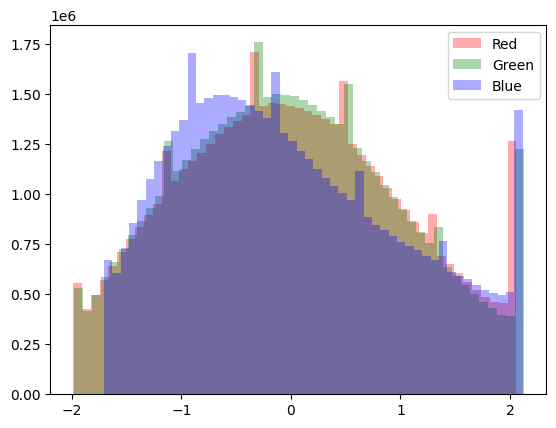

In [4]:
if GET_DATASET_STATS_FLAG:
    imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [5]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].squeeze(0)
        image_data = image_data.permute(1,2,0)
        plt.imshow(image_data)
        plt.title(CIFAR10_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

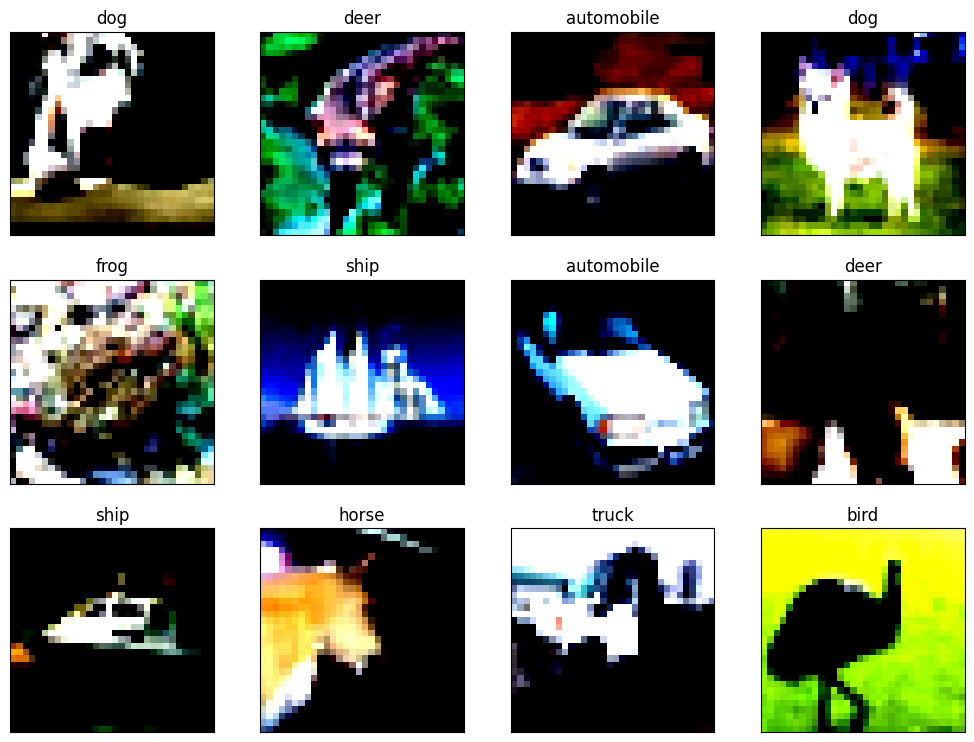

In [6]:
dataset_visualizer(test_loader)

In [7]:
criterion = nn.CrossEntropyLoss()
train_loss_data = []
test_loss_data = []
test_accuracy = []

best_loss = float('inf')   # initialize with infinity

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

        train_loss_data.append(loss.item())


def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


# Working - Trial 1

In [8]:
model = Net()

dummy_data = torch.randn(5, 3, 32, 32)
dummy_output = model(dummy_data)
logger.info(f"CNN output shape = {dummy_output.shape}")
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,320
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]             544
       BatchNorm2d-8           [-1, 32, 32, 32]              64
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           9,248
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

In [ ]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1,  patience=10)

for epoch in range(10):
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader, epoch)
    reduce_lr.step(test_loss)

loss=0.9752432703971863 batch_id=1562: 100%|██████████| 1563/1563 [03:40<00:00,  7.10it/s]


TypeError: test() missing 1 required positional argument: 'epoch'